In [1]:
import yfinance as yf

In [2]:
data_raw = yf.download('AMZN',period='5y',interval='1d')

/tmp/ipython-input-1292485264.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_raw = yf.download('AMZN',period='5y',interval='1d')
[*********************100%***********************]  1 of 1 completed


In [3]:
data_raw.head()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2020-11-02,150.223999,153.985504,147.505997,153.087006,145148000
2020-11-03,152.420502,153.744995,149.048996,150.926498,97958000
2020-11-04,162.057999,162.242493,156.986496,157.999496,136780000
2020-11-05,166.100006,168.339996,164.444000,165.998505,115786000
2020-11-06,165.568497,166.100006,161.600006,165.231995,92946000


In [4]:
data_raw.tail()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2025-10-27,226.970001,228.399994,225.539993,227.660004,38267000
2025-10-28,229.250000,231.490005,226.210007,228.220001,47100000
2025-10-29,230.300003,232.820007,227.759995,231.669998,52036200
2025-10-30,222.860001,228.440002,222.750000,227.059998,102252900
2025-10-31,244.220001,250.500000,243.979996,250.199997,166088899


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [6]:
data = data_raw[['Close']].copy()
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

In [7]:
print(data)

Price        Date       Close
Ticker                   AMZN
0      2020-11-02  150.223999
1      2020-11-03  152.420502
2      2020-11-04  162.057999
3      2020-11-05  166.100006
4      2020-11-06  165.568497
...           ...         ...
1251   2025-10-27  226.970001
1252   2025-10-28  229.250000
1253   2025-10-29  230.300003
1254   2025-10-30  222.860001
1255   2025-10-31  244.220001

[1256 rows x 2 columns]


In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

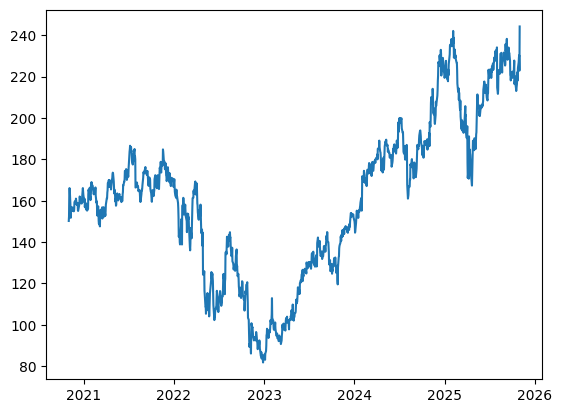

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [10]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Ticker,AMZN,,,,,,,
Date,,,,,,,,
2020-11-11,156.869507,151.751007,157.186996,165.568497,166.100006,162.057999,152.420502,150.223999
2020-11-12,155.514008,156.869507,151.751007,157.186996,165.568497,166.100006,162.057999,152.420502
2020-11-13,156.440506,155.514008,156.869507,151.751007,157.186996,165.568497,166.100006,162.057999
2020-11-16,156.552994,156.440506,155.514008,156.869507,151.751007,157.186996,165.568497,166.100006
2020-11-17,156.783005,156.552994,156.440506,155.514008,156.869507,151.751007,157.186996,165.568497
...,...,...,...,...,...,...,...,...
2025-10-27,226.970001,224.210007,221.089996,217.949997,222.029999,216.479996,213.039993,214.470001
2025-10-28,229.250000,226.970001,224.210007,221.089996,217.949997,222.029999,216.479996,213.039993


In [11]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[156.86950684, 151.75100708, 157.18699646, ..., 162.05799866,
        152.42050171, 150.22399902],
       [155.51400757, 156.86950684, 151.75100708, ..., 166.1000061 ,
        162.05799866, 152.42050171],
       [156.44050598, 155.51400757, 156.86950684, ..., 165.5684967 ,
        166.1000061 , 162.05799866],
       ...,
       [230.30000305, 229.25      , 226.97000122, ..., 217.94999695,
        222.02999878, 216.47999573],
       [222.86000061, 230.30000305, 229.25      , ..., 221.08999634,
        217.94999695, 222.02999878],
       [244.22000122, 222.86000061, 230.30000305, ..., 224.21000671,
        221.08999634, 217.94999695]])

In [12]:
shifted_df_as_np.shape

(1249, 8)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.07574499, -0.12717164, -0.05932354, ...,  0.00147279,
        -0.11881549, -0.14623065],
       [-0.09243834, -0.06328622, -0.12717164, ...,  0.05192221,
         0.00147279, -0.11881549],
       [-0.08102826, -0.08020458, -0.06328622, ...,  0.04528829,
         0.05192221,  0.00147279],
       ...,
       [ 0.82857145,  0.84011486,  0.81165756, ...,  0.69907637,
         0.75000001,  0.68072888],
       [ 0.73694581,  0.85322024,  0.84011486, ...,  0.73826758,
         0.69907637,  0.75000001],
       [ 1.        ,  0.7603595 ,  0.85322024, ...,  0.7772093 ,
         0.73826758,  0.69907637]])

In [14]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1249, 7), (1249,))

In [15]:
X = dc(np.flip(X, axis=1))
X

array([[-0.14623065, -0.11881549,  0.00147279, ...,  0.04528829,
        -0.05932354, -0.12717164],
       [-0.11881549,  0.00147279,  0.05192221, ..., -0.05932354,
        -0.12717164, -0.06328622],
       [ 0.00147279,  0.05192221,  0.04528829, ..., -0.12717164,
        -0.06328622, -0.08020458],
       ...,
       [ 0.68072888,  0.75000001,  0.69907637, ...,  0.7772093 ,
         0.81165756,  0.84011486],
       [ 0.75000001,  0.69907637,  0.73826758, ...,  0.81165756,
         0.84011486,  0.85322024],
       [ 0.69907637,  0.73826758,  0.7772093 , ...,  0.84011486,
         0.85322024,  0.7603595 ]])

In [16]:
split_index = int(len(X) * 0.95)

split_index

1186

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1186, 7), (63, 7), (1186,), (63,))

In [18]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1186, 7, 1), (63, 7, 1), (1186, 1), (63, 1))

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1186, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1186, 1]),
 torch.Size([63, 1]))

In [20]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [21]:
train_dataset

In [22]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [24]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model_rnn = RNN(1, 4, 1)
model_rnn.to(device)

RNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
def train_one_epoch():
    model_rnn.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model_rnn(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    print()


In [26]:
def validate_one_epoch():
    model_rnn.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model_rnn(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))

    print('***************************************************')
    print()


In [27]:
learning_rate = 0.001

num_epochs = 50

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()


Epoch: 1

Val Loss: 0.389
***************************************************

Epoch: 2

Val Loss: 0.435
***************************************************

Epoch: 3

Val Loss: 0.238
***************************************************

Epoch: 4

Val Loss: 0.055
***************************************************

Epoch: 5

Val Loss: 0.045
***************************************************

Epoch: 6

Val Loss: 0.048
***************************************************

Epoch: 7

Val Loss: 0.037
***************************************************

Epoch: 8

Val Loss: 0.036
***************************************************

Epoch: 9

Val Loss: 0.031
***************************************************

Epoch: 10

Val Loss: 0.026
***************************************************

Epoch: 11

Val Loss: 0.029
***************************************************

Epoch: 12

Val Loss: 0.026
***************************************************

Epoch: 13

Val Loss: 0.021
**********************

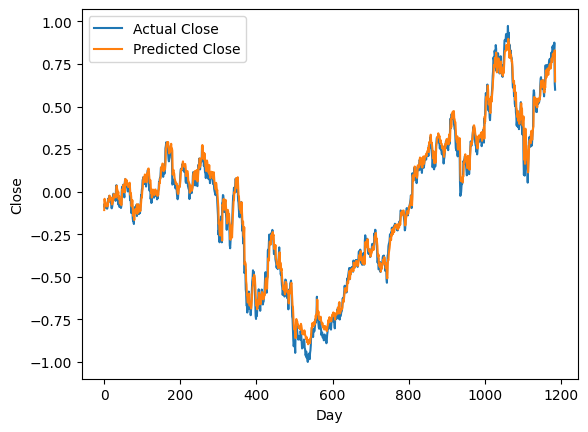

In [28]:
with torch.no_grad():
    predicted_rnn = model_rnn(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted_rnn, label='Predicted Close')

plt.xlabel('Day')
plt.ylabel('Close')

plt.legend()

plt.show()


In [29]:
train_predictions_rnn = predicted_rnn.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))

dummies[:, 0] = train_predictions_rnn

dummies = scaler.inverse_transform(dummies)

train_predictions_rnn = dc(dummies[:, 0])

train_predictions_rnn

array([154.24520512, 159.60632991, 157.92299219, ..., 227.36392668,
       230.41480428, 215.5944873 ])

In [30]:
dummies = np.zeros((X_train.shape[0], lookback+1))

dummies[:, 0] = y_train.flatten()

dummies = scaler.inverse_transform(dummies)

new_y_train_rnn = dc(dummies[:, 0])

new_y_train_rnn


/tmp/ipython-input-2337536201.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([156.86950689, 155.51400777, 156.44050627, ..., 234.11000288,
       214.74999784, 211.64999528])

# Plotting the actual vs. predicted values for visualization

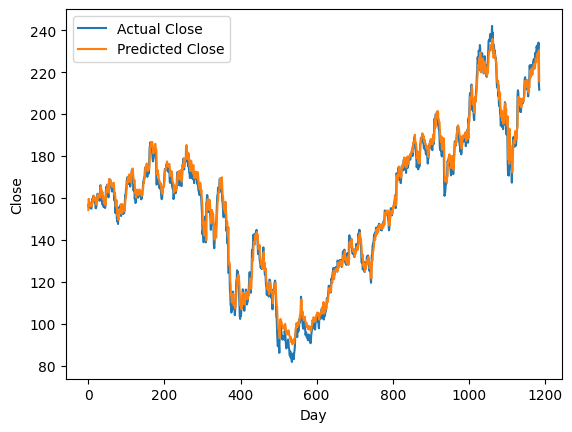

In [31]:
plt.plot(new_y_train_rnn, label='Actual Close')

plt.plot(train_predictions_rnn, label='Predicted Close')

plt.xlabel('Day')

plt.ylabel('Close')

plt.legend()

plt.show()


# Generating predictions for the test dataset using the trained RNN model


In [32]:
test_predictions_rnn = model_rnn(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))

dummies[:, 0] = test_predictions_rnn

dummies = scaler.inverse_transform(dummies)

test_predictions_rnn = dc(dummies[:, 0])

test_predictions_rnn

array([214.75712217, 216.70016666, 222.26688574, 221.77706395,
       220.98273034, 219.7671224 , 220.2048669 , 222.83672072,
       227.53501221, 227.13740497, 227.58338214, 225.27407359,
       222.58179365, 221.74792776, 227.01529437, 225.62147657,
       226.051545  , 226.34582043, 228.08716704, 226.16985144,
       223.7832207 , 224.64304779, 231.60554967, 228.43481686,
       231.15192546, 232.84908866, 226.97367125, 227.5815817 ,
       226.50281701, 228.80748894, 230.45005809, 228.28999745,
       228.11519004, 228.4168802 , 225.57047373, 220.73797674,
       220.8922533 , 219.10978692, 220.17059559, 221.56648002,
       219.00749085, 219.87499403, 221.19271412, 218.78514597,
       220.19412233, 220.81282091, 223.24361088, 224.95856069,
       216.15556207, 220.06541978, 217.07692362, 216.46897445,
       215.71419732, 214.29973252, 216.76463409, 220.66040286,
       216.91904617, 219.77395633, 222.12764674, 224.02412658,
       225.84337134, 226.68388725, 221.22383466])

# Preparing the actual y_test values (target labels) for comparison with model predictions

In [33]:
dummies = np.zeros((X_test.shape[0], lookback+1))

dummies[:, 0] = y_test.flatten()

dummies = scaler.inverse_transform(dummies)

new_y_test_rnn = dc(dummies[:, 0])

new_y_test_rnn

/tmp/ipython-input-2715475211.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([213.74999764, 222.30999955, 223.13000397, 222.69000407,
       221.30000496, 221.47000151, 224.55999516, 230.9799978 ,
       231.02999877, 231.4900068 , 228.00999488, 223.80999985,
       221.94999831, 228.83999853, 227.94000029, 228.71000857,
       229.11999626, 231.60000799, 229.00000069, 225.33999783,
       225.9900057 , 235.67999293, 232.33      , 235.83999509,
       238.24000332, 230.3299996 , 229.94999507, 228.14999375,
       231.42999208, 234.05000267, 231.61999676, 231.22999785,
       231.4799979 , 227.63000487, 220.71000697, 220.21000687,
       218.14999174, 219.77999652, 222.16999584, 219.5700079 ,
       220.63000347, 222.4100015 , 219.50999318, 220.89999229,
       221.77999692, 225.22000226, 227.74000605, 216.36999371,
       220.070008  , 216.38999701, 215.5700071 , 214.47000011,
       213.0399944 , 216.47999489, 222.02999697, 217.94999751,
       221.08999698, 224.21000767, 226.97000261, 229.25000074,
       230.30000192, 222.86000062, 244.22000122])

# Plotting the actual vs. predicted values for the test dataset

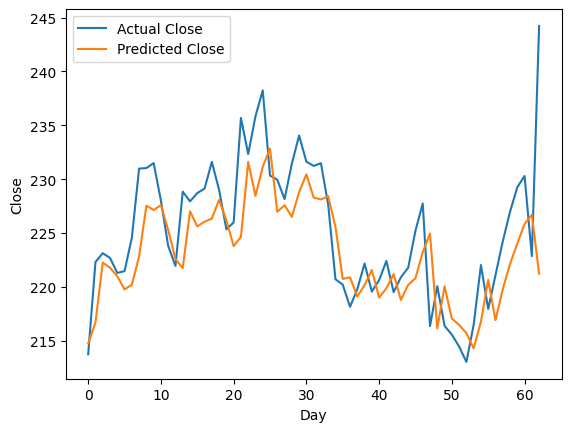

In [34]:
plt.plot(new_y_test_rnn, label='Actual Close')

plt.plot(test_predictions_rnn, label='Predicted Close')

plt.xlabel('Day')
plt.ylabel('Close')

plt.legend()

plt.show()




---



---

